# Figure 3 and 4
This notebook recreates Figure 3 and 4 in Rein & Tamayo 2016. The figure illustrates the use of second order variational equations and Newton's method in fitting a radial velocity curve to an $N$-body simulation. The method is conceptually similar to that presented in Figure 2, but has a more realistic application (RV fitting).

We start by import the REBOUND, numpy and matplotlib packages. 

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Let us first create a fake radial velocity data set at a few random points in time and plot the curve.

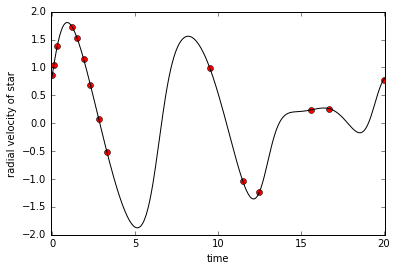

In [2]:
sample_times = np.array([0.,0.1,0.3,1.2,1.5,1.9,2.3,2.8,3.3,9.5,11.5,12.5,15.6,16.7,20.])
def generatedata(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((len(sample_times)))
    for i,t in enumerate(sample_times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return samples
def generateplotpoints(x,N):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    samples = np.zeros((N))
    times = np.linspace(sample_times[0]-0.1,sample_times[-1]+0.1,N)
    for i,t in enumerate(times):
        sim.integrate(t)
        samples[i] = sim.particles[0].vx
    return times, samples

x_true = (1.0,0.2500)
samples_true = generatedata(x_true)
t,s = generateplotpoints(x_true,400)
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_xlabel("time")
ax.set_xlim(t[0],t[-1])
ax.set_ylabel("radial velocity of star")
im = ax.plot(sample_times, 1000.*samples_true, "ro") # we scale the velocity by a factor of 1000 (units don't matter for this example)
im = ax.plot(t, 1000.*s, "r-",color="black")
plt.savefig('paper_test3a.pdf',bbox_inches='tight')

The following function defines a *goodness of fit* (the $\chi^2$) for a given set of initial conditions, $a$ and $e$.

In [3]:
def chi2(x):
    a, e = x
    sim = rebound.Simulation()
    sim.ri_ias15.min_dt = 0.01
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.move_to_com()
    l = 0.
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
    return l

The following function calculates not only the goodness of fit, $\chi^2$, but also the derivates of $\chi^2$ with respect to $a$ and $e$ up to second order by using variational equations.

In [4]:
def chi2_derivatives(x):
    a, e = x
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(primary=sim.particles[0],m=1e-3, a=a, e=e)
    sim.add(primary=sim.particles[0],m=1e-3, a=1.3,f=1.4)
    sim.ri_ias15.min_dt = 0.01
    var_da    = sim.add_variation()
    var_dda   = sim.add_variation(order=2,first_order=var_da)
    var_de    = sim.add_variation()
    var_dde   = sim.add_variation(order=2,first_order=var_de,first_order_2=var_de)
    var_da_de = sim.add_variation(order=2,first_order=var_da,first_order_2=var_de)
    var_da.vary(1,"a")
    var_dda.vary(1,"a")
    var_de.vary(1,"e")
    var_dde.vary(1,"e")
    var_da_de.vary(1,"a","e")
   
    sim.move_to_com()
    
    l = 0.
    d = np.zeros((2))
    dd = np.zeros((2,2))
    
    for i, t in enumerate(sample_times):
        sim.integrate(t)
        rvobs = samples_true[i]
        rv = sim.particles[0].vx
        l += (rv-rvobs)*(rv-rvobs)
        d[0] += 2. * var_da.particles[0].vx*(rv-rvobs)
        d[1] += 2. * var_de.particles[0].vx*(rv-rvobs)
        dd[0][0] += 2. * var_dda.particles[0].vx*(rv-rvobs)
        dd[0][0] += 2. * var_da.particles[0].vx*var_da.particles[0].vx
        dd[1][0] += 2. * var_da_de.particles[0].vx*(rv-rvobs)
        dd[1][0] += 2. * var_da.particles[0].vx*var_de.particles[0].vx
        dd[1][1] += 2. * var_dde.particles[0].vx*(rv-rvobs)
        dd[1][1] += 2. * var_de.particles[0].vx*var_de.particles[0].vx

    dd[0][1] = dd[1][0]
             
    return l, d, dd

To help convergence in non-convex areas of parameter space, we implement the softabs metric.

In [5]:
def softabs(hessians):
    alpha = 10000000.0
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    return H_twig

For plotting purposes, we calculate the $\chi^2$ value on a grid in the $a$-$e$ plane.

In [6]:
N=100
grid = np.zeros((N,N))
grid_a = np.linspace(0.94,1.075,N)
grid_e = np.linspace(0.0,0.4,N)
for i, a in enumerate(grid_a):
    for j, e in enumerate(grid_e):
        l = chi2((a,e))
        grid[j][i] = l

Finally, we start the actual iteration with Newton's method. The starting point is $a=0.96, e=0.2$. 

In [8]:
x = np.array((0.96, 0.2))
N_it = 30
chain = np.zeros((N_it,2))
for i in range(N_it):    
    l, d, dd = chi2_derivatives(x)
    G = softabs(dd)
    Delta_x = -np.dot(np.linalg.inv(G),d)
    chain[i] = x
    x = x + 0.5*Delta_x # We take a slightly smaller stepsize to help convergence

Let us now plot the parameter space in the $a$/$e$ plane. The color and the contours correspond to the $\chi^2$ values. The path of Newton's method is shown as well.

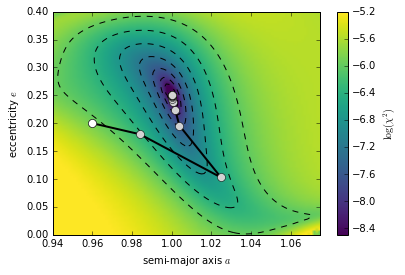

In [9]:
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
extent = [min(grid_a),max(grid_a),min(grid_e),max(grid_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")
matplotlib.rcParams['contour.negative_linestyle'] = 'dashed'
im = ax.imshow(np.log10(grid), cmap="viridis", vmin=-8.5, vmax = -5.2, origin="lower",aspect='auto', extent=extent) #interpolation="none",
ax.contour(grid_a, grid_e, np.clip(np.log10(grid),-8.5,-5.8),colors="black")
ax.plot(chain[:,0],chain[:,1],color="black",lw=2)
ax.plot(chain[:,0],chain[:,1],"ro",color="lightgray",markersize=8)
ax.plot(chain[0,0],chain[0,1],"ro",color="white",markersize=8)
cb = plt.colorbar(im, ax=ax)
cb.set_label('$\log(\chi^2)$')
plt.savefig('paper_test3b.pdf',bbox_inches='tight')